In [39]:
import pickle

from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch

device = 'cuda'

In [40]:
with open('/home/apankov/optimization_vectorization/datasets'
          '/results/abc/our_curves/intermediate_output/'
          '00050000_99fd5beca7714bc586260b6a_step_000.pickle', 'rb') as handle:
    intermediate_output = pickle.load(handle)

print(intermediate_output.keys())
print(intermediate_output['patches_rgb'].shape)
print(intermediate_output['patches_vector'].shape)

dict_keys(['patches_rgb', 'patches_vector', 'patches_offsets', 'cleaned_image_shape', 'options', 'image_name'])
(1470, 64, 64, 1)
torch.Size([1470, 10, 8])


In [41]:
def qbezier_to_cbezier(qbezier):
    p0 = np.asarray(qbezier)[..., :2]
    qp1 = np.asarray(qbezier)[..., 2:4]
    qp2 = np.asarray(qbezier)[..., 4:6]
    rest = np.asarray(qbezier)[..., 6:]
    p1 = (qp1 * 2 + p0) / 3
    p2 = (qp1 * 2 + qp2) / 3
    return np.concatenate([p0, p1, p2, qp2, rest], axis=-1)


In [42]:
cbezier = qbezier_to_cbezier(intermediate_output['patches_vector'][1000:1001, :, :10])

In [43]:
from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
renderer = Renderer((64, 64), linecaps='butt', device=device, dtype=torch.float32)

In [44]:
torch.from_numpy(cbezier).to(device)

tensor([[[-6.9827e-03,  5.1086e+01,  5.8266e+00,  3.4090e+01,  1.1670e+01,
           1.7070e+01,  1.7523e+01,  2.7418e-02,  4.3688e+00,  6.4000e+01],
         [ 6.1323e+00,  3.2657e+01,  9.7047e+00,  2.7250e+01,  1.2900e+01,
           2.1827e+01,  1.5717e+01,  1.6389e+01,  4.6023e+00,  6.3999e+01],
         [ 1.7345e+01,  1.3429e+01,  2.0870e+01,  2.5482e+01,  2.3951e+01,
           3.7614e+01,  2.6586e+01,  4.9824e+01,  4.9580e+00,  6.3998e+01],
         [ 2.9134e+01, -1.8659e-02,  4.0665e+01,  1.9903e+01,  5.2359e+01,
           3.9666e+01,  6.4213e+01,  5.9269e+01,  5.1866e+00,  6.4000e+01],
         [ 1.4169e+00, -6.7953e-03,  2.6575e+00,  3.1388e-01,  3.7542e+00,
           5.0581e-01,  4.7071e+00,  5.6899e-01,  3.7940e-01,  3.4192e+01],
         [ 5.5918e-03, -3.3928e-03,  3.3212e-03, -5.3274e-03, -1.1517e-03,
          -3.4613e-03, -7.8268e-03,  2.2056e-03,  1.8858e-03,  5.0280e+00],
         [-1.7370e-03, -4.7003e-03, -3.4464e-03,  1.2015e-03, -3.8794e-03,
           3.5466e-

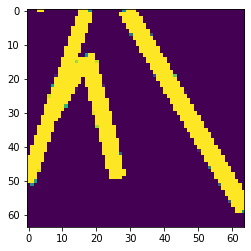

In [45]:
plt.imshow(renderer.render(torch.from_numpy(cbezier).to(device))[0].detach().cpu().numpy())

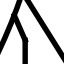

In [46]:
Image.fromarray(np.uint8(intermediate_output['patches_rgb'][1000, ..., 0]))

In [48]:
from vectran.data.graphics.graphics import Path, VectorImage
from vectran.data.graphics.units import Pixels
from vectran.data.graphics_primitives import PT_LINE, PT_QBEZIER


def vector_image_from_patches(primitives, patch_offsets, control_points_n, patch_size, image_size,
                              pixel_center_coodinates_are_integer=False, scale=None,
                              min_width=.3, min_confidence=.5, min_length=1.7):
    r"""
    Parameters
    ----------
    primitives : array_like
        of shape [patches_n, primitives_n, parameters_n]
    patch_offsets : array_like
        of shape [patches_n, spatial_dims_n]
    patch_size : tuple
        [width, height]
    Returns
    -------
    """
    primitives = torch.tensor(primitives)
    dtype = primitives.dtype
    patch_offsets = torch.tensor(patch_offsets).type(dtype)

    # 0. Fix bug in offsets
    patch_offsets = torch.stack([patch_offsets[:, 1], patch_offsets[:, 0]], dim=1)

    patches_n, primitives_n, parameters_n = primitives.shape
    spatial_dims_n = patch_offsets.shape[1]

    # 1. Shift primitives w.r.t patch offsets
    parameters_dim_i = 1
    primitive_shifts = torch.cat([patch_offsets] * control_points_n +
                                 [patch_offsets.new_zeros(patches_n, 2)], dim=parameters_dim_i)
    primitive_shifts = primitive_shifts.reshape(patches_n, 1, parameters_n)
    primitives = primitives + primitive_shifts
    del primitive_shifts

    # 2. Shift their bounding boxes
    # FIXME: hardcoded spatial_dims_n
    spatial_dims_dim_i = 1
    width, height = patch_size
    minx = 0
    maxx = width
    miny = 0
    maxy = height
    bounding_boxes = torch.tensor([minx, maxx, miny, maxy], dtype=dtype)
    if pixel_center_coodinates_are_integer:
        bounding_boxes -= .5
    box_shifts = patch_offsets.repeat_interleave(2, dim=spatial_dims_dim_i)
    bounding_boxes = bounding_boxes.reshape(1, -1)
    bounding_boxes = bounding_boxes + box_shifts
    del box_shifts, patch_offsets

    # 3. Get rid of patch dimension
    primitives = primitives.reshape(-1, parameters_n)
    bounding_boxes = (bounding_boxes.reshape(patches_n, 1, -1).expand(patches_n, primitives_n, -1)
                                    .reshape(patches_n * primitives_n, -1))

    # 4. Get rid of primitives with small width, low confidence, and nans in parameters
    #    get rid of confidence parameter
    good_primitives = ((primitives[:, -2] >= min_width) & (primitives[:, -1] >= min_confidence) &
                       torch.isfinite(primitives).all(dim=1))
    primitives = primitives[good_primitives, :-1].contiguous()
    bounding_boxes = bounding_boxes[good_primitives].contiguous()
    del good_primitives, patches_n
    primitives_n = len(primitives)
    parameters_n -= 1

    # 5. Get rid of too short primitives
    length = primitives.new_zeros(primitives_n)
    p1 = primitives[:, :spatial_dims_n]
    for p2_i in range(1, control_points_n):
        p2 = primitives[:, spatial_dims_n * p2_i: spatial_dims_n * (p2_i + 1)]
        length += torch.norm(p2 - p1, dim=1)
        p1 = p2
    del p1, p2

    good_primitives = length >= min_length
    primitives = primitives[good_primitives].contiguous()
    bounding_boxes = bounding_boxes[good_primitives].contiguous()
    del length, good_primitives
    primitives_n = len(primitives)

    # 6. Convert primitives to Paths and assemble VectorImage
    # FIXME: hardcoded spatial_dims_n
    paths = list(filter(None, map(primitive_to_path_and_crop, zip(primitives.numpy(), bounding_boxes.numpy()))))
    del primitives, bounding_boxes

    width = Pixels(image_size[1])
    height = Pixels(image_size[0])
    view_size = width, height

    vector_image = VectorImage(paths, view_size=view_size)
    if scale:
        vector_image.scale(scale)
        width = Pixels(image_size[1])
        height = Pixels(image_size[0])
        vector_image.view_width = width
        vector_image.view_height = height
    return vector_image


def primitive_to_path_and_crop(arg):
    primitive_parameters, bbox = arg
    params_n = len(primitive_parameters)
    if params_n == 5:
        path = Path.from_primitive(PT_LINE, primitive_parameters)
    elif params_n:
        path = Path.from_primitive(PT_QBEZIER, primitive_parameters)
    else:
        raise NotImplementedError(f'Unknown primitive with {params_n} parameters')

    path.crop(bbox)
    if len(path) == 0:
        return None
    else:
        return path

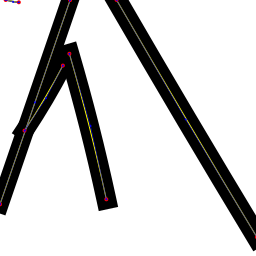

In [49]:
import sys

sys.path.append('/home/apankov/dev.vectorizationn')
from vectran.renderers.cairo import render_with_skeleton, PT_QBEZIER


dimensions = np.array([1, 1]) * 64

valid_primitives = intermediate_output['patches_vector'][1000].numpy()
valid_primitives = valid_primitives[valid_primitives[:, -1] > .5 * dimensions[0]]

scale = 4
Image.fromarray(
    render_with_skeleton({PT_QBEZIER: valid_primitives * scale}, dimensions * scale)
)

In [50]:
valid_primitives

array([[-6.9827437e-03,  5.1085503e+01,  8.7434654e+00,  2.5591869e+01,
         1.7522636e+01,  2.7417839e-02,  4.3688078e+00,  6.4000000e+01],
       [ 6.1322560e+00,  3.2656940e+01,  1.1490914e+01,  2.4546371e+01,
         1.5716836e+01,  1.6388815e+01,  4.6022892e+00,  6.3999298e+01],
       [ 1.7344643e+01,  1.3429232e+01,  2.2633045e+01,  3.1508041e+01,
         2.6585997e+01,  4.9824478e+01,  4.9580255e+00,  6.3998039e+01],
       [ 2.9133663e+01, -1.8658936e-02,  4.6431293e+01,  2.9864510e+01,
         6.4213226e+01,  5.9269276e+01,  5.1865969e+00,  6.3999863e+01],
       [ 1.4168836e+00, -6.7953169e-03,  3.2777643e+00,  4.7422102e-01,
         4.7071323e+00,  5.6898683e-01,  3.7940246e-01,  3.4191780e+01]],
      dtype=float32)

## Patches to whole

In [51]:
output_vector_image = vector_image_from_patches(
    primitives=intermediate_output['patches_vector'],
    patch_offsets=intermediate_output['patches_offsets'],
    image_size=intermediate_output['cleaned_image_shape'],
    control_points_n=3 if 'bezier' else 2 if 'line' else 'etc',
    patch_size=dimensions,
    pixel_center_coodinates_are_integer=False,
    min_width=.3,
    min_confidence=.5 * 64,
    min_length=1.7)

/home/apankov/miniconda3/envs/apankov/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


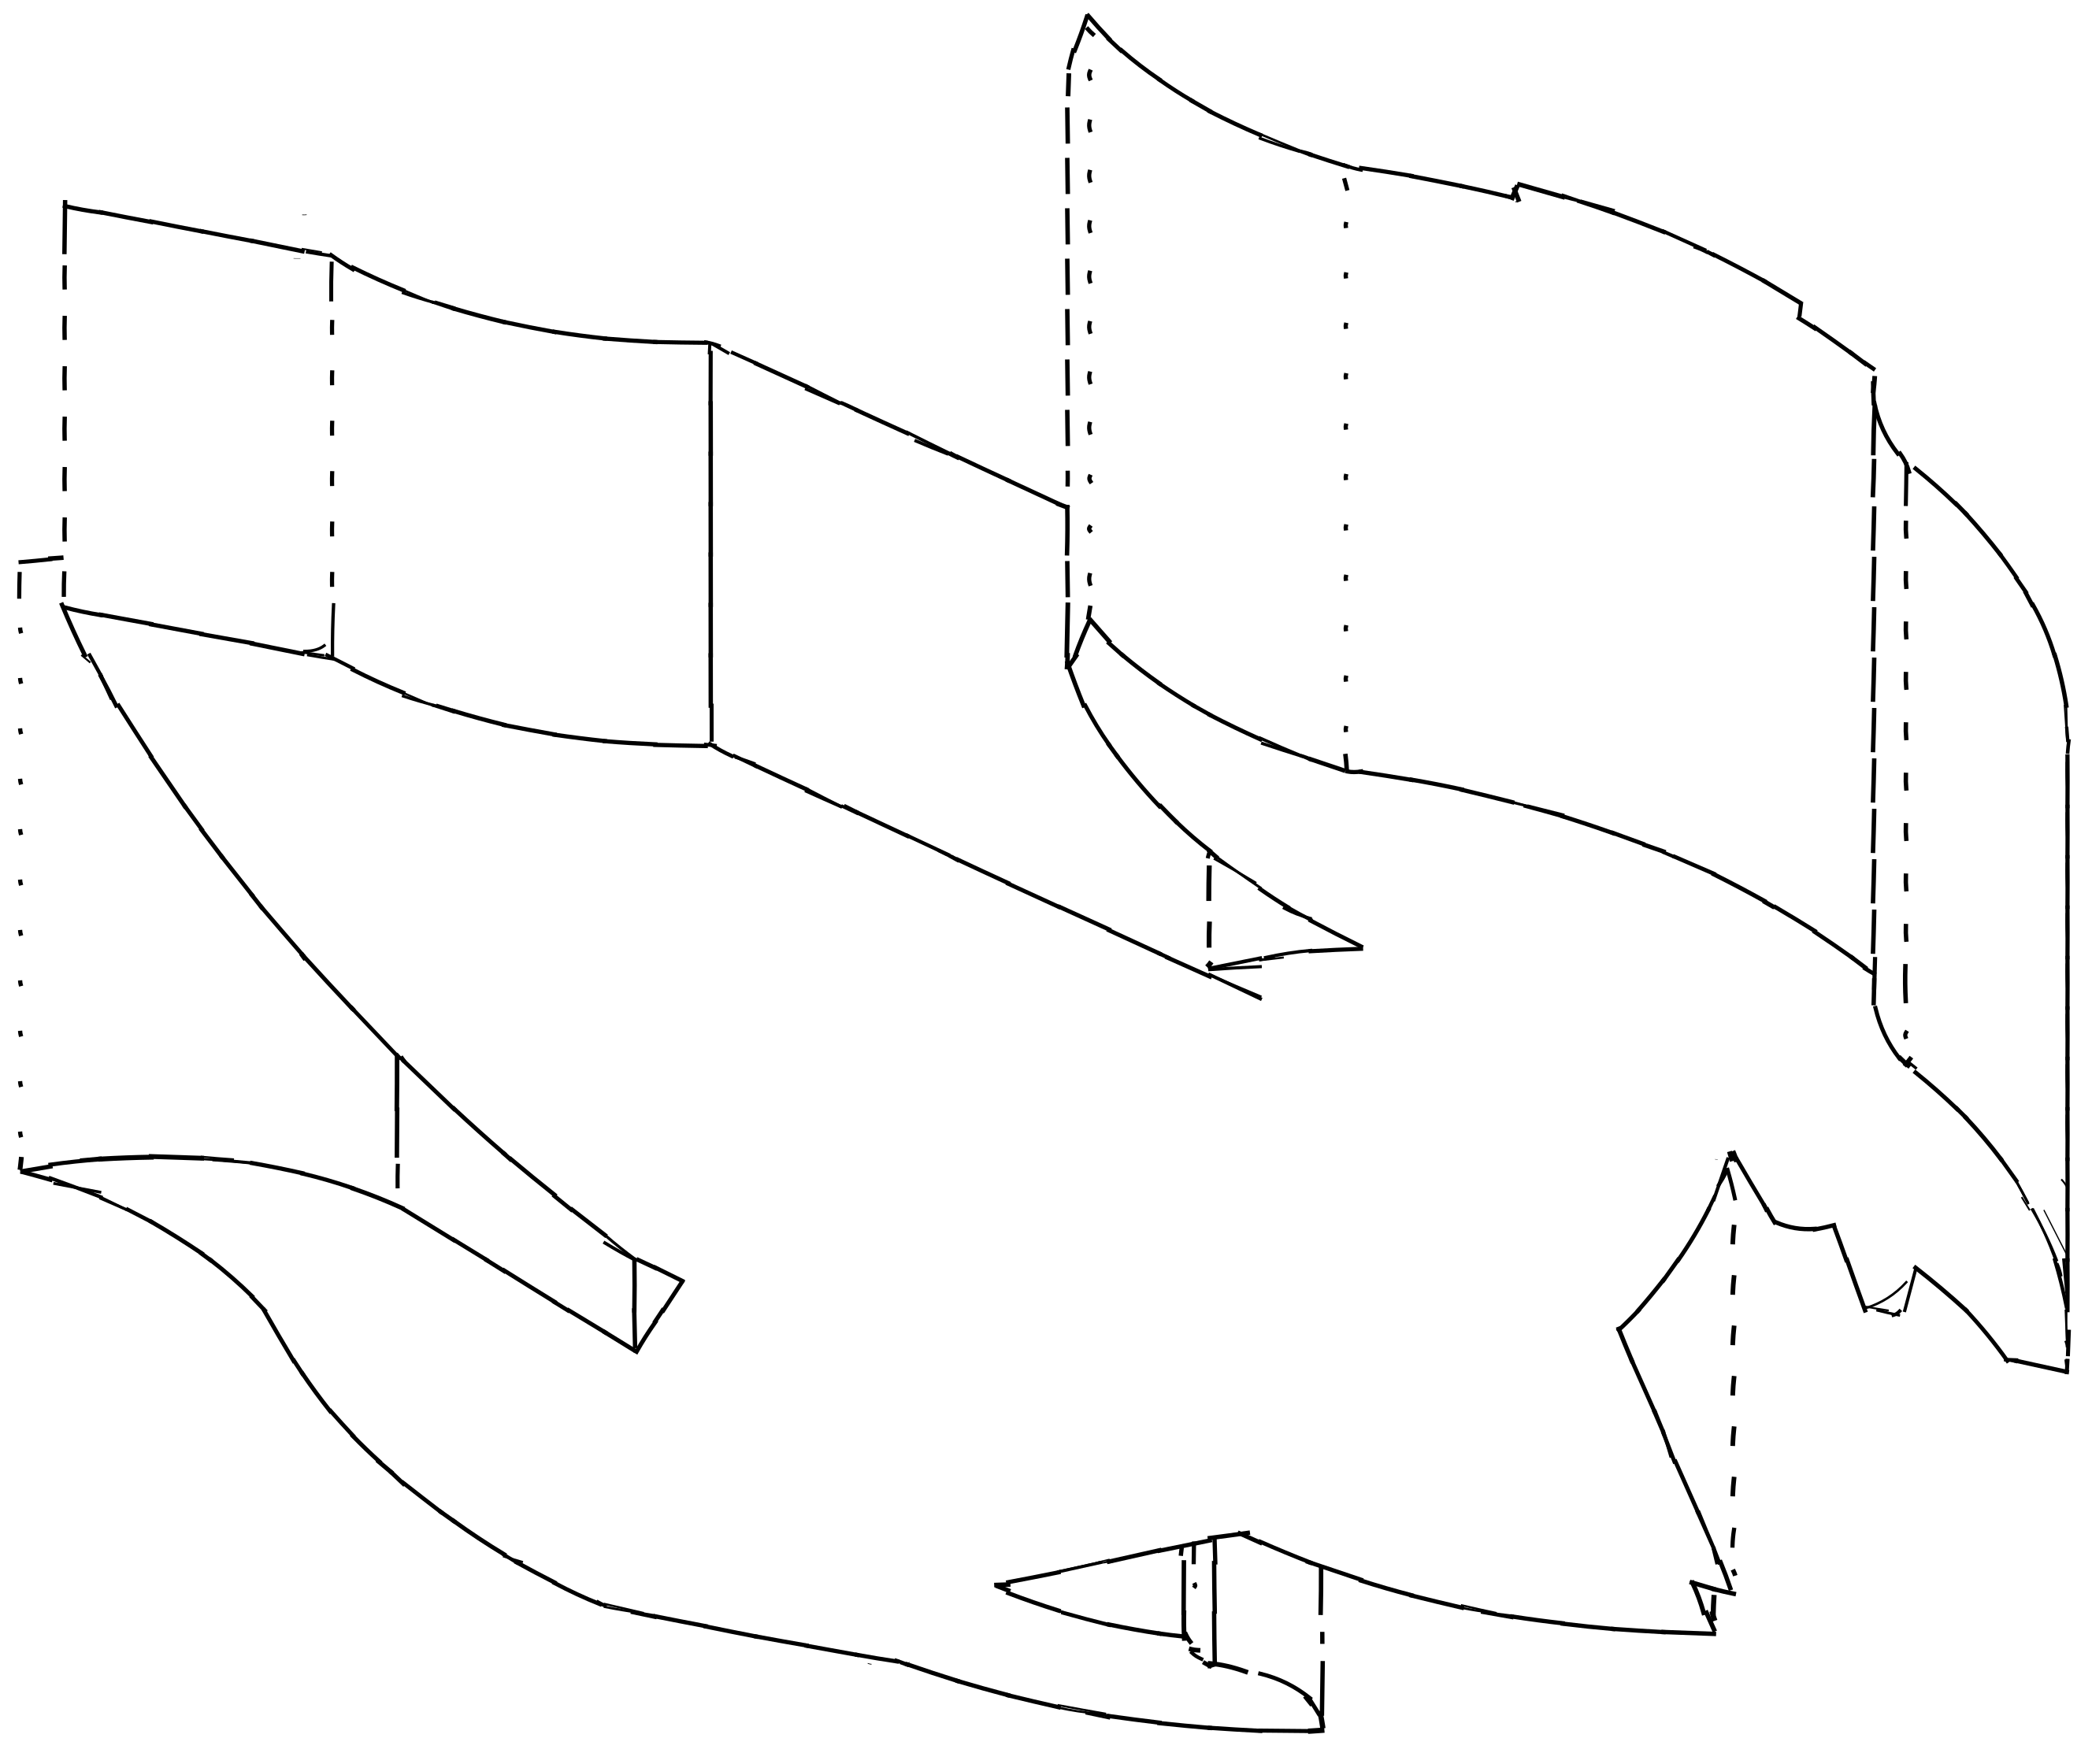

In [52]:
from vectran.renderers.cairo import render

Image.fromarray(output_vector_image.render(render))

## Metrics

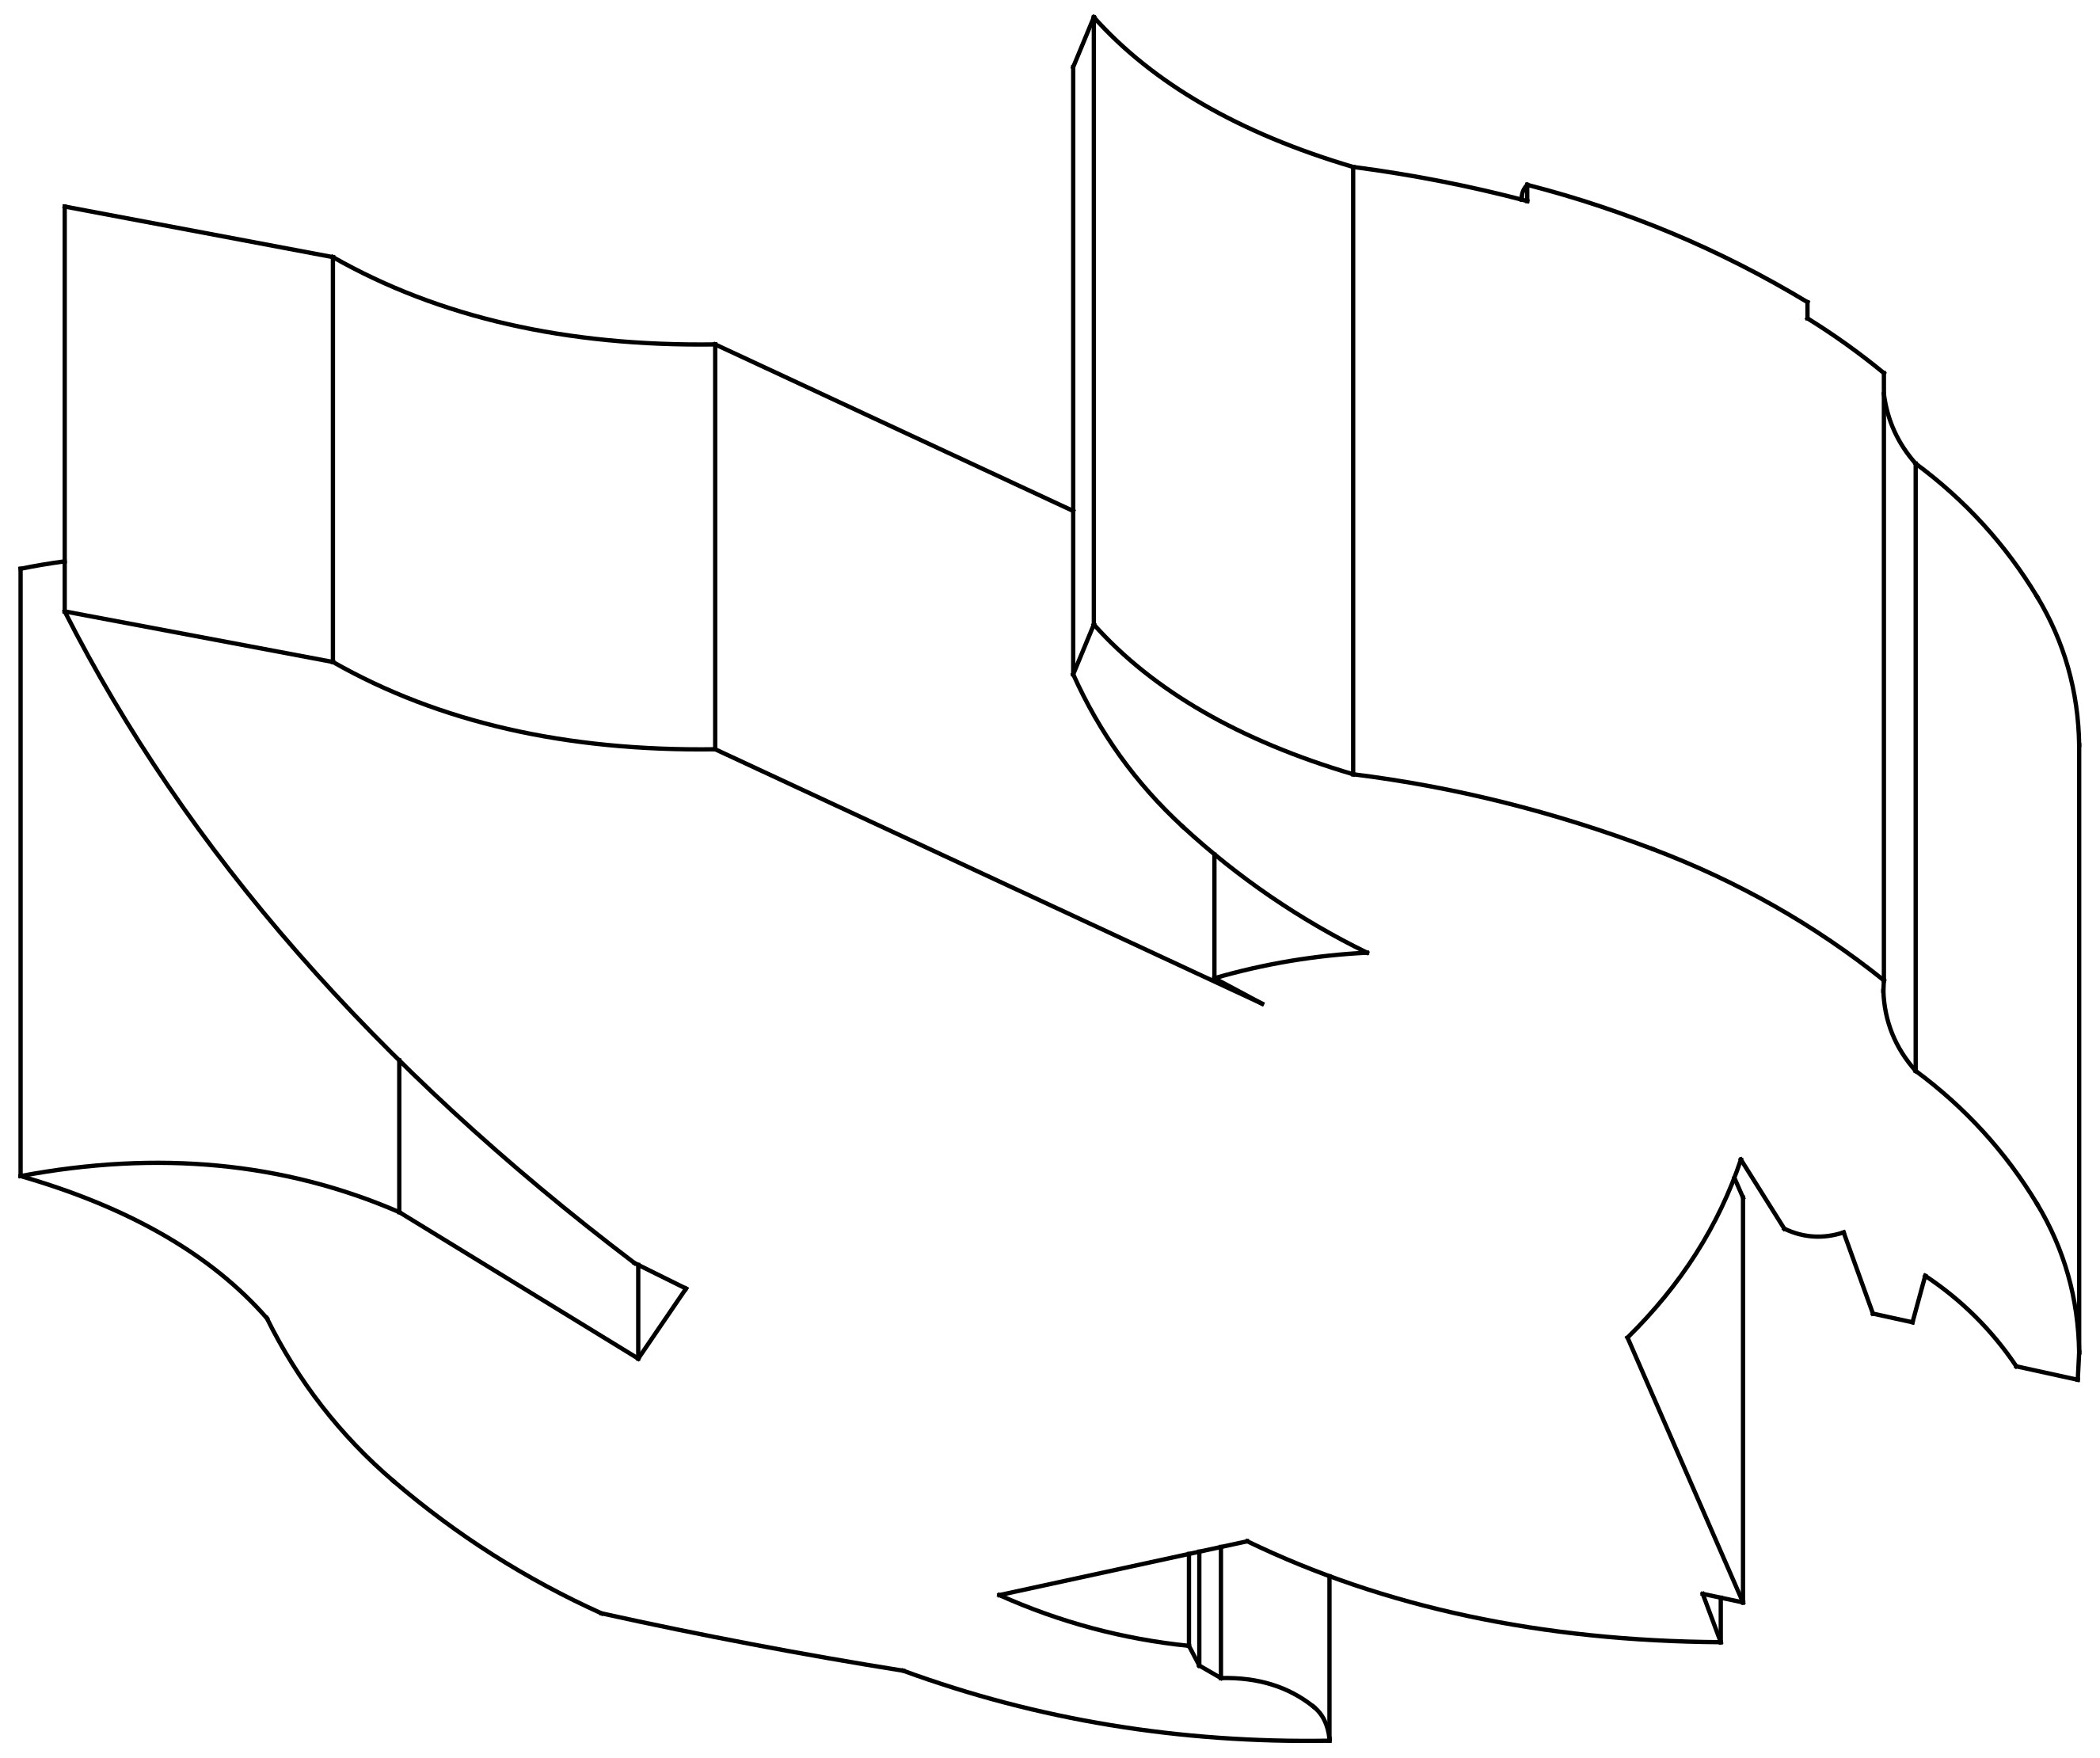

In [7]:
from vectran.data.graphics.graphics import VectorImage


gt_vector_image = VectorImage.from_svg(
    '/home/ovoinov/remotes/root.zhores'
    '/gpfs/data/gpfs0/3ddl/vectorization/datasets/test_sets/abc/'
    '00050000_99fd5beca7714bc586260b6a_step_000.svg').with_filled_removed()

Image.fromarray(gt_vector_image.render(render))

In [8]:
from vectran.metrics.cvpr20.skeleton_metrics import cpch_distance, number_of_primitives
from vectran.metrics.cvpr20.iou import iou_raster_reference, iou_vector_reference


def get_most_common_width(vector_image):
    widths = np.fromiter((float(path.width.as_pixels()) for path in vector_image.paths if path.width is not None),
                         dtype=np.float)
    values, counts = np.unique(widths, return_counts=True)
    return values[np.argmax(counts)]


gt_width = get_most_common_width(gt_vector_image)


{
    'IOU with predicted width': iou_vector_reference(output_vector_image, gt_vector_image, width=None),
    'IOU with mean width': iou_vector_reference(output_vector_image, gt_vector_image, width='mean'),
    'IOU with fixed width': iou_vector_reference(output_vector_image, gt_vector_image, width=gt_width),
    'Number of primitives in gt': number_of_primitives(gt_vector_image),
    'Number of primitives in prediction': number_of_primitives(output_vector_image),
    **cpch_distance(output_vector_image, gt_vector_image)
}

{'IOU with predicted width': 0.6625225647132297,
 'IOU with mean width': 0.6568690704894872,
 'IOU with fixed width': 0.6568690704894872,
 'Number of primitives in gt': 81,
 'Number of primitives in prediction': 559,
 'Chamfer distance in pixels squared': 2698425.75,
 'Mean mean minimal distance in pixels': 1.7321830987930298,
 'Hausdorff distance in pixels': 45.21456527709961}